# 資料挖掘作業 2：吸菸預測模型

本專案透過多個機器學習模型的集成方法來預測吸菸狀態。我們使用了三種強大的梯度提升樹模型：XGBoost、LightGBM 和 CatBoost，並透過 Optuna 進行超參數優化，最後根據驗證集上的 AUC 得分進行加權集成。

## 1. 導入所需套件

首先導入所有需要使用的套件和函式庫。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from datetime import datetime
import optuna
import shap
import time
import warnings

warnings.filterwarnings("ignore")
start_time = time.time()

c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 資料載入與探索

在這個部分，我們載入訓練和測試資料集，並進行初步的資料探索。

In [2]:
# 載入資料集
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# 顯示訓練集的基本資訊
print(f"訓練集形狀: {train.shape}")
print(f"測試集形狀: {test.shape}")
train.head()

訓練集形狀: (15000, 24)
測試集形狀: (10000, 23)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,25.0,170.0,60.0,75.0,1.5,1.2,1.0,1.0,100.0,...,50.0,81.0,15.2,1.0,0.8,18.0,16.0,19.0,1.0,1.0
1,1,40.0,165.0,65.0,79.0,1.0,1.2,1.0,1.0,130.0,...,58.0,130.0,12.8,1.0,0.6,31.0,26.0,33.0,0.0,0.0
2,2,50.0,170.0,80.0,93.0,1.2,1.0,1.0,1.0,130.0,...,44.0,130.0,16.7,1.0,0.9,38.0,46.0,69.0,0.0,1.0
3,3,75.0,160.0,60.0,89.0,0.8,1.0,1.0,1.0,116.0,...,44.0,149.0,15.1,1.0,1.1,24.0,22.0,20.0,0.0,0.0
4,4,60.0,170.0,75.0,89.0,0.8,0.8,1.0,1.0,138.0,...,38.0,122.0,14.6,1.0,1.0,26.0,27.0,97.0,0.0,1.0


In [3]:
# 檢查訓練集和測試集的缺失值
print("訓練集缺失值統計:")
missing_train = train.isnull().sum()
missing_percentage_train = 100 * missing_train / len(train)
missing_info_train = pd.concat([missing_train, missing_percentage_train], axis=1)
missing_info_train.columns = ['缺失值數量', '缺失百分比 (%)']
missing_info_train = missing_info_train[missing_info_train['缺失值數量'] > 0]
print(missing_info_train if not missing_info_train.empty else "訓練集無缺失值")

print("\n測試集缺失值統計:")
missing_test = test.isnull().sum()
missing_percentage_test = 100 * missing_test / len(test)
missing_info_test = pd.concat([missing_test, missing_percentage_test], axis=1)
missing_info_test.columns = ['缺失值數量', '缺失百分比 (%)']
missing_info_test = missing_info_test[missing_info_test['缺失值數量'] > 0]
print(missing_info_test if not missing_info_test.empty else "測試集無缺失值")

訓練集缺失值統計:
訓練集無缺失值

測試集缺失值統計:
測試集無缺失值


## 3. 資料前處理

資料前處理是機器學習流程中非常重要的一環。在這一部分，我們將執行以下步驟：
1. 合併訓練集和測試集以進行一致的特徵工程
2. 處理欄位名稱（替換空格為下劃線）
3. 辨識並分類特徵（類別型和數值型）
4. 進行缺失值處理和特徵轉換

In [74]:
# 合併訓練集和測試集以統一進行特徵處理
test['smoking'] = np.nan
data = pd.concat([train, test], ignore_index=True)

# 3. Feature Engineering

# data['BMI'] = data['weight(kg)'] / (data['height(cm)'] / 100) ** 2
# data['LDL_to_HDL'] = data['LDL'] / (data['HDL'] + 1e-5)
# data['waist_BMI_ratio'] = data['waist(cm)'] / data['BMI']
# data['liver_mean'] = data[['AST', 'ALT', 'Gtp']].mean(axis=1)

# 定義類別型和數值型特徵
categorical_columns = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
numerical_columns = [col for col in data.columns if col not in categorical_columns + ['smoking', 'id']
                     and data[col].dtype in ['float64', 'int64']]

# 顯示分類後的特徵數量
print(f"類別型特徵數量: {len(categorical_columns)}")
print(f"數值型特徵數量: {len(numerical_columns)}")

類別型特徵數量: 4
數值型特徵數量: 18


### 3.1 缺失值處理與特徵轉換

我們使用以下方法處理資料：
1. 使用 SimpleImputer 填補缺失值（以中位數填補）
2. 應用 Yeo-Johnson 變換來處理偏態分佈
3. 使用 MinMaxScaler 將數值特徵縮放到相同範圍

In [75]:

# 應用 Power Transform 處理偏態分佈
power_transformer = PowerTransformer(method='yeo-johnson')
data[numerical_columns] = power_transformer.fit_transform(data[numerical_columns])

# 特徵縮放
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

### 3.2 類別型特徵編碼與特徵工程

在這個部分，我們將：
1. 對類別型特徵進行 One-Hot 編碼
2. 應用 KMeans 聚類作為特徵工程的一部分，創建新的聚類特徵

In [76]:
# One-Hot 編碼
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(data[categorical_columns])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_columns), index=data.index)
data = data.drop(columns=categorical_columns)
data = pd.concat([data, encoded_df], axis=1)

In [77]:

# 使用 KMeans 進行聚類特徵工程
kmeans = KMeans(n_clusters=5, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(data[numerical_columns])

# 檢視特徵工程後的資料
print(f"處理後的特徵數量: {data.shape[1]}")

處理後的特徵數量: 28


In [78]:
print(data.columns)

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar',
       'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'smoking', 'hearing(left)_2.0',
       'hearing(right)_2.0', 'Urine protein_2.0', 'Urine protein_3.0',
       'Urine protein_4.0', 'Urine protein_5.0', 'dental caries_1.0',
       'kmeans_cluster'],
      dtype='object')


## 4. 資料分割

將資料分割為訓練集、驗證集和測試集。這是模型訓練和評估的重要步驟。

In [79]:
# 定義需要省略的特徵
features_to_drop = ['hearing(left)_2.0', 'hearing(right)_2.0']  # 替換為你想刪除的特徵名稱

# 合併訓練集和測試集後，刪除不需要的特徵
data = data.drop(columns=features_to_drop, errors='ignore')

# 分割資料
train_length = len(train)
X = data.iloc[:train_length].drop(columns=['smoking', 'id'], errors='ignore')
X_test = data.iloc[train_length:].drop(columns=['smoking', 'id'], errors='ignore')
y = data.iloc[:train_length]['smoking'].astype(int)

# 分割訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# 檢查刪除後的數據集形狀
print(f"訓練集形狀: {X_train.shape}")
print(f"驗證集形狀: {X_val.shape}")
print(f"測試集形狀: {X_test.shape}")
print(X_train.columns)

訓練集形狀: (13500, 24)
驗證集形狀: (1500, 24)
測試集形狀: (10000, 24)
Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar',
       'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'Urine protein_2.0',
       'Urine protein_3.0', 'Urine protein_4.0', 'Urine protein_5.0',
       'dental caries_1.0', 'kmeans_cluster'],
      dtype='object')


## 5. 模型超參數優化與訓練

在這個部分，我們將使用 Optuna 來為三種不同的梯度提升樹模型尋找最佳的超參數。超參數優化是提高模型性能的關鍵步驟。

### 5.1 XGBoost 模型優化與訓練

XGBoost 是一種高效能的梯度提升樹實現，特別適合結構化/表格式資料。

In [70]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'auc'
    }
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", auc)
    return auc

# 創建並執行 Optuna 研究對象
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

# 顯示最佳參數
print("最佳 XGBoost 參數:")
print(study_xgb.best_params)
print(f"最佳 AUC: {study_xgb.best_value:.4f}")

# 使用最佳參數訓練模型
best_xgb = xgb.XGBClassifier(**study_xgb.best_params, tree_method='hist', device='cuda', eval_metric='logloss')
best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
xgb_log = best_xgb.evals_result()
xgb_preds = best_xgb.predict_proba(X_test)[:, 1]

[I 2025-04-11 15:18:09,445] A new study created in memory with name: no-name-8f55765c-6ee4-45dd-ab96-4ac4105b269b
[I 2025-04-11 15:18:12,100] Trial 0 finished with value: 0.8842681770928881 and parameters: {'n_estimators': 391, 'max_depth': 3, 'learning_rate': 0.027471153085804494, 'subsample': 0.9501528167152348, 'colsample_bytree': 0.6912379340055468, 'min_child_weight': 9, 'gamma': 4.9166038814202055, 'reg_alpha': 3.343827644787309, 'reg_lambda': 3.7563201498826535}. Best is trial 0 with value: 0.8842681770928881.
[I 2025-04-11 15:18:16,995] Trial 1 finished with value: 0.8778224943435455 and parameters: {'n_estimators': 723, 'max_depth': 10, 'learning_rate': 0.16397934945301268, 'subsample': 0.7897802669861929, 'colsample_bytree': 0.779236141643087, 'min_child_weight': 3, 'gamma': 0.8885074694266187, 'reg_alpha': 2.9739849254533106, 'reg_lambda': 3.293193455747626}. Best is trial 0 with value: 0.8842681770928881.
[I 2025-04-11 15:18:18,777] Trial 2 finished with value: 0.8838534978

最佳 XGBoost 參數:
{'n_estimators': 816, 'max_depth': 4, 'learning_rate': 0.12239844484580008, 'subsample': 0.7036826704920517, 'colsample_bytree': 0.865011618620694, 'min_child_weight': 5, 'gamma': 3.9485373505061485, 'reg_alpha': 0.8232939290116134, 'reg_lambda': 4.445274556676931}
最佳 AUC: 0.8888


### 5.2 LightGBM 模型優化與訓練

LightGBM 是一個高效、低記憶體佔用的梯度提升框架，使用基於直方圖的分割尋找策略，適合大型資料集。

In [71]:
def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'device_type': 'gpu',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0)
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(30)])
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", auc)
    return auc

# 創建並執行 Optuna 研究對象
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

# 顯示最佳參數
print("最佳 LightGBM 參數:")
print(study_lgb.best_params)
print(f"最佳 AUC: {study_lgb.best_value:.4f}")

# 使用最佳參數訓練模型
best_lgb = LGBMClassifier(**study_lgb.best_params, verbosity=-1)
best_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc', callbacks=[lgb.early_stopping(30)])
lgb_log = best_lgb.evals_result_
lgb_preds = best_lgb.predict_proba(X_test)[:, 1]

[I 2025-04-11 15:20:07,775] A new study created in memory with name: no-name-9b14710c-98ca-449e-8b82-0bdddc3069bb


Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:20:14,364] Trial 0 finished with value: 0.8877767076377424 and parameters: {'n_estimators': 171, 'learning_rate': 0.052426175821890256, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.9158191697359058, 'colsample_bytree': 0.8330174211676535, 'reg_alpha': 3.883205680345705, 'reg_lambda': 1.1128106702253926}. Best is trial 0 with value: 0.8877767076377424.


Early stopping, best iteration is:
[130]	valid_0's auc: 0.887777
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:20:17,139] Trial 1 finished with value: 0.8874346450192626 and parameters: {'n_estimators': 161, 'learning_rate': 0.1878245070416095, 'num_leaves': 61, 'max_depth': 3, 'min_child_samples': 55, 'subsample': 0.7899107081935061, 'colsample_bytree': 0.9929948005631304, 'reg_alpha': 2.4111483326409515, 'reg_lambda': 1.4670022857143268}. Best is trial 0 with value: 0.8877767076377424.


Early stopping, best iteration is:
[103]	valid_0's auc: 0.887435
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:20:21,270] Trial 2 finished with value: 0.8874365559836116 and parameters: {'n_estimators': 475, 'learning_rate': 0.08161759861686109, 'num_leaves': 127, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.8292353886805457, 'colsample_bytree': 0.8997181240804898, 'reg_alpha': 3.9753070646049715, 'reg_lambda': 1.6676350654022682}. Best is trial 0 with value: 0.8877767076377424.


Early stopping, best iteration is:
[173]	valid_0's auc: 0.887437
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:20:24,232] Trial 3 finished with value: 0.8894220479422735 and parameters: {'n_estimators': 508, 'learning_rate': 0.1414639715995695, 'num_leaves': 26, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.9655190245334688, 'colsample_bytree': 0.6883526645539345, 'reg_alpha': 0.7167516959744785, 'reg_lambda': 3.295929105288296}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[52]	valid_0's auc: 0.889422
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:20:32,312] Trial 4 finished with value: 0.8884187916590227 and parameters: {'n_estimators': 410, 'learning_rate': 0.05748428149753546, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 47, 'subsample': 0.9077624792212053, 'colsample_bytree': 0.6297769442754838, 'reg_alpha': 0.6544214905572943, 'reg_lambda': 2.2821570605509933}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[115]	valid_0's auc: 0.888419
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:20:37,077] Trial 5 finished with value: 0.8850918027273283 and parameters: {'n_estimators': 123, 'learning_rate': 0.19943489567945044, 'num_leaves': 146, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7812964506991722, 'colsample_bytree': 0.7844424609991241, 'reg_alpha': 4.727011149635352, 'reg_lambda': 3.4022764957576284}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[24]	valid_0's auc: 0.885092
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:20:40,090] Trial 6 finished with value: 0.8875340151654132 and parameters: {'n_estimators': 676, 'learning_rate': 0.16433077562874598, 'num_leaves': 46, 'max_depth': 12, 'min_child_samples': 84, 'subsample': 0.8653859193295497, 'colsample_bytree': 0.6884035735778014, 'reg_alpha': 4.433293351355617, 'reg_lambda': 2.0997020415067857}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[29]	valid_0's auc: 0.887534
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:20:51,859] Trial 7 finished with value: 0.8883270653702685 and parameters: {'n_estimators': 956, 'learning_rate': 0.027189062028796604, 'num_leaves': 93, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8534043571591996, 'colsample_bytree': 0.6054656025613149, 'reg_alpha': 1.140483680664706, 'reg_lambda': 4.507074694986472}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[479]	valid_0's auc: 0.888327
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:21:01,720] Trial 8 finished with value: 0.884419143276463 and parameters: {'n_estimators': 297, 'learning_rate': 0.0603043824638643, 'num_leaves': 147, 'max_depth': 11, 'min_child_samples': 66, 'subsample': 0.9057237443392578, 'colsample_bytree': 0.9755077180092899, 'reg_alpha': 0.5543894608478062, 'reg_lambda': 2.0377853116558153}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[141]	valid_0's auc: 0.884419
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:21:06,540] Trial 9 finished with value: 0.8853287623066104 and parameters: {'n_estimators': 724, 'learning_rate': 0.10659803578574484, 'num_leaves': 54, 'max_depth': 11, 'min_child_samples': 74, 'subsample': 0.7490921955915986, 'colsample_bytree': 0.7981321452937824, 'reg_alpha': 2.0641810146677337, 'reg_lambda': 4.7867697730328524}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[78]	valid_0's auc: 0.885329
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:21:10,248] Trial 10 finished with value: 0.8877518651012047 and parameters: {'n_estimators': 648, 'learning_rate': 0.13308817199210163, 'num_leaves': 24, 'max_depth': 8, 'min_child_samples': 35, 'subsample': 0.6756927842544374, 'colsample_bytree': 0.7108907341178415, 'reg_alpha': 0.005100316834144469, 'reg_lambda': 0.030343892184885313}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[73]	valid_0's auc: 0.887752
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:21:16,135] Trial 11 finished with value: 0.8875665015593469 and parameters: {'n_estimators': 435, 'learning_rate': 0.13753356550058057, 'num_leaves': 100, 'max_depth': 9, 'min_child_samples': 40, 'subsample': 0.9880464182061655, 'colsample_bytree': 0.6101441112738056, 'reg_alpha': 1.4084007498706421, 'reg_lambda': 3.206028283624757}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[81]	valid_0's auc: 0.887567
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:21:32,431] Trial 12 finished with value: 0.8825979942518192 and parameters: {'n_estimators': 343, 'learning_rate': 0.010696262576266297, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.9987222205067658, 'colsample_bytree': 0.6869203902266411, 'reg_alpha': 1.2693177536627247, 'reg_lambda': 3.0630898262968342}. Best is trial 3 with value: 0.8894220479422735.


Did not meet early stopping. Best iteration is:
[343]	valid_0's auc: 0.882598
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:21:38,482] Trial 13 finished with value: 0.8850650492264416 and parameters: {'n_estimators': 550, 'learning_rate': 0.09912019089301778, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.946104404005786, 'colsample_bytree': 0.6556931916377524, 'reg_alpha': 0.012656025158081174, 'reg_lambda': 3.9477389449232794}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[93]	valid_0's auc: 0.885065
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:21:43,588] Trial 14 finished with value: 0.885663181067694 and parameters: {'n_estimators': 838, 'learning_rate': 0.13169539108770298, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 96, 'subsample': 0.9399678727988359, 'colsample_bytree': 0.7474440480595133, 'reg_alpha': 3.2125256176418793, 'reg_lambda': 2.741039683883926}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[68]	valid_0's auc: 0.885663
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:21:51,277] Trial 15 finished with value: 0.8881264141136183 and parameters: {'n_estimators': 335, 'learning_rate': 0.05313300661377352, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.6272620021697191, 'colsample_bytree': 0.6451976912583819, 'reg_alpha': 1.8109987900805236, 'reg_lambda': 3.916371693950675}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[183]	valid_0's auc: 0.888126
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:21:54,590] Trial 16 finished with value: 0.8853192074848651 and parameters: {'n_estimators': 545, 'learning_rate': 0.157986743350647, 'num_leaves': 25, 'max_depth': 10, 'min_child_samples': 46, 'subsample': 0.8858393858413739, 'colsample_bytree': 0.7241925406325296, 'reg_alpha': 0.7178011446524875, 'reg_lambda': 0.5472709652155512}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[69]	valid_0's auc: 0.885319
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:22:01,051] Trial 17 finished with value: 0.8853956460588271 and parameters: {'n_estimators': 444, 'learning_rate': 0.08930553784839622, 'num_leaves': 130, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.9662363918868997, 'colsample_bytree': 0.6553059088882884, 'reg_alpha': 2.8443548933591516, 'reg_lambda': 2.3673233089643673}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[87]	valid_0's auc: 0.885396
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:22:07,498] Trial 18 finished with value: 0.8834216198862592 and parameters: {'n_estimators': 264, 'learning_rate': 0.12236809469083688, 'num_leaves': 106, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.7348753798206692, 'colsample_bytree': 0.8686861100023998, 'reg_alpha': 0.7222007435773352, 'reg_lambda': 3.702801051735255}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[50]	valid_0's auc: 0.883422
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:22:13,639] Trial 19 finished with value: 0.8860453739375039 and parameters: {'n_estimators': 594, 'learning_rate': 0.07023241894118964, 'num_leaves': 85, 'max_depth': 9, 'min_child_samples': 63, 'subsample': 0.8266574949949708, 'colsample_bytree': 0.7592241114220365, 'reg_alpha': 1.7519992573092984, 'reg_lambda': 2.5541728006478635}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[92]	valid_0's auc: 0.886045
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:22:24,961] Trial 20 finished with value: 0.8888411147801627 and parameters: {'n_estimators': 836, 'learning_rate': 0.038273859693719214, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 32, 'subsample': 0.9204481209920757, 'colsample_bytree': 0.6469199503742955, 'reg_alpha': 0.37285992593621964, 'reg_lambda': 0.9969758797942769}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[254]	valid_0's auc: 0.888841
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:22:34,957] Trial 21 finished with value: 0.8891965541490857 and parameters: {'n_estimators': 778, 'learning_rate': 0.03426879104563848, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 34, 'subsample': 0.9290933823739844, 'colsample_bytree': 0.6279685303214957, 'reg_alpha': 0.4587863512566561, 'reg_lambda': 0.9422083192746414}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[213]	valid_0's auc: 0.889197
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:22:45,021] Trial 22 finished with value: 0.887417446340121 and parameters: {'n_estimators': 804, 'learning_rate': 0.03145526106723082, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 36, 'subsample': 0.9509796644152803, 'colsample_bytree': 0.6798914400645567, 'reg_alpha': 0.3463006787795404, 'reg_lambda': 0.6332860668369933}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[225]	valid_0's auc: 0.887417
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:22:56,705] Trial 23 finished with value: 0.8880557084327035 and parameters: {'n_estimators': 998, 'learning_rate': 0.029520085000349264, 'num_leaves': 32, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.9253408536048686, 'colsample_bytree': 0.7117826170047229, 'reg_alpha': 1.0170701006675866, 'reg_lambda': 1.1426991500247716}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[288]	valid_0's auc: 0.888056
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:23:12,599] Trial 24 finished with value: 0.8876505839907052 and parameters: {'n_estimators': 864, 'learning_rate': 0.013742183917986508, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.9740516872514906, 'colsample_bytree': 0.6020147342484032, 'reg_alpha': 0.25696924797705173, 'reg_lambda': 0.29536603658623994}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[501]	valid_0's auc: 0.887651
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:23:16,681] Trial 25 finished with value: 0.8864638751299456 and parameters: {'n_estimators': 755, 'learning_rate': 0.15583594057210198, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 34, 'subsample': 0.8849353802190392, 'colsample_bytree': 0.6658330214163043, 'reg_alpha': 1.551934895447093, 'reg_lambda': 0.9166387412574417}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[54]	valid_0's auc: 0.886464
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:23:29,623] Trial 26 finished with value: 0.8870505411851037 and parameters: {'n_estimators': 912, 'learning_rate': 0.036800952643548025, 'num_leaves': 65, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.9986430171976132, 'colsample_bytree': 0.6326273686511102, 'reg_alpha': 0.8920661289894456, 'reg_lambda': 1.667548453218302}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[183]	valid_0's auc: 0.887051
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:23:33,701] Trial 27 finished with value: 0.8860587506879471 and parameters: {'n_estimators': 749, 'learning_rate': 0.11699596009395011, 'num_leaves': 34, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8413854968882457, 'colsample_bytree': 0.7495296472563426, 'reg_alpha': 2.2250072320727527, 'reg_lambda': 2.920176415745975}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[62]	valid_0's auc: 0.886059
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:23:38,926] Trial 28 finished with value: 0.885775927964288 and parameters: {'n_estimators': 619, 'learning_rate': 0.07517085362353715, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.8748079158403704, 'colsample_bytree': 0.7019231884768989, 'reg_alpha': 0.28158755871771285, 'reg_lambda': 1.5089925255547247}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[113]	valid_0's auc: 0.885776
Training until validation scores don't improve for 30 rounds


[I 2025-04-11 15:23:44,942] Trial 29 finished with value: 0.8860300862227114 and parameters: {'n_estimators': 909, 'learning_rate': 0.14384993408059188, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.9237815431370868, 'colsample_bytree': 0.7295531361771322, 'reg_alpha': 3.0682576324011572, 'reg_lambda': 1.0094056122236157}. Best is trial 3 with value: 0.8894220479422735.


Early stopping, best iteration is:
[76]	valid_0's auc: 0.88603
最佳 LightGBM 參數:
{'n_estimators': 508, 'learning_rate': 0.1414639715995695, 'num_leaves': 26, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.9655190245334688, 'colsample_bytree': 0.6883526645539345, 'reg_alpha': 0.7167516959744785, 'reg_lambda': 3.295929105288296}
最佳 AUC: 0.8894
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.889382	valid_0's binary_logloss: 0.396681


### 5.3 CatBoost 模型優化與訓練

CatBoost 是一種高效能的梯度提升樹實現，尤其擅長處理類別型特徵，並自動處理缺失值。

In [72]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0,
        'eval_metric': 'AUC',
        'random_state': 42,
        'task_type': 'CPU',
        'od_type': 'Iter',
        'od_wait': 30
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", auc)
    return auc

# 創建並執行 Optuna 研究對象
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30)

# 顯示最佳參數
print("最佳 CatBoost 參數:")
print(study_cat.best_params)
print(f"最佳 AUC: {study_cat.best_value:.4f}")

# 使用最佳參數訓練模型
best_cat = CatBoostClassifier(**study_cat.best_params)
best_cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, verbose=False)
cat_log = best_cat.get_evals_result()
cat_preds = best_cat.predict_proba(X_test)[:, 1]

[I 2025-04-11 15:23:46,740] A new study created in memory with name: no-name-b2f0a3ca-bd40-4b4b-98a4-47d3ed900726
[I 2025-04-11 15:23:52,337] Trial 0 finished with value: 0.8813310248883997 and parameters: {'iterations': 303, 'learning_rate': 0.11004591408393442, 'depth': 10, 'l2_leaf_reg': 2.5616379621494394, 'bagging_temperature': 0.3066371322499656, 'border_count': 52}. Best is trial 0 with value: 0.8813310248883997.
[I 2025-04-11 15:23:55,018] Trial 1 finished with value: 0.8867486088179538 and parameters: {'iterations': 943, 'learning_rate': 0.10353388121763837, 'depth': 8, 'l2_leaf_reg': 2.290753738526506, 'bagging_temperature': 0.2387959024482459, 'border_count': 39}. Best is trial 1 with value: 0.8867486088179538.
[I 2025-04-11 15:24:01,785] Trial 2 finished with value: 0.8869473491102549 and parameters: {'iterations': 221, 'learning_rate': 0.04067249118965192, 'depth': 8, 'l2_leaf_reg': 6.174476288885693, 'bagging_temperature': 0.1159873192798091, 'border_count': 188}. Best is

最佳 CatBoost 參數:
{'iterations': 980, 'learning_rate': 0.0671176692702377, 'depth': 7, 'l2_leaf_reg': 7.9404426291158865, 'bagging_temperature': 0.4318559466711649, 'border_count': 182}
最佳 AUC: 0.8898


## 6. 模型集成與預測

在這部分，我們將根據各個模型在驗證集上的 AUC 表現，進行自動加權集成，結合三個模型的預測結果。

In [73]:
# 計算基於 AUC 的權重
auc_xgb = study_xgb.best_value or 0
auc_lgb = study_lgb.best_value or 0
auc_cat = study_cat.best_value or 0
total_auc = auc_xgb + auc_lgb + auc_cat
total_auc = auc_xgb + auc_cat
w_xgb = auc_xgb / total_auc
w_lgb = auc_lgb / total_auc
w_cat = auc_cat / total_auc

print(f"使用自動 AUC 權重：XGB = {w_xgb:.4f}, LGB = {w_lgb:.4f}, CAT = {w_cat:.4f}")

# 加權集成預測
final_preds = w_xgb * xgb_preds + w_lgb * lgb_preds + w_cat * cat_preds
#final_preds = xgb_preds 
#final_preds = lgb_preds 
#final_preds = cat_preds
# 生成提交檔案
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'submission_{timestamp}.csv'
sample_submission['smoking'] = final_preds
sample_submission.to_csv(filename, index=False)
print(f"提交檔案已儲存為 {filename}")

使用自動 AUC 權重：XGB = 0.4997, LGB = 0.5001, CAT = 0.5003
提交檔案已儲存為 submission_20250411_152712.csv


## 7. 模型評估與分析

在這一部分，我們將通過各種方式分析模型性能和特徵重要性。

### 7.1 儲存 Optuna 超參數優化結果

記錄所有超參數優化試驗的結果，便於後續分析。

In [42]:
# 收集所有 Optuna 試驗結果
optuna_trials = []
for study, name in [(study_xgb, 'XGBoost'), (study_lgb, 'LightGBM'), (study_cat, 'CatBoost')]:
    for t in study.trials:
        optuna_trials.append({
            'model': name,
            'score': t.user_attrs.get('mean_auc', t.value),
            **t.user_attrs.get('params', {})
        })
pd.DataFrame(optuna_trials).to_csv('optuna_trials_log.csv', index=False)
print("超參數優化記錄已保存至 optuna_trials_log.csv")

超參數優化記錄已保存至 optuna_trials_log.csv


### 7.2 繪製訓練曲線

視覺化三個模型在訓練過程中的性能變化。

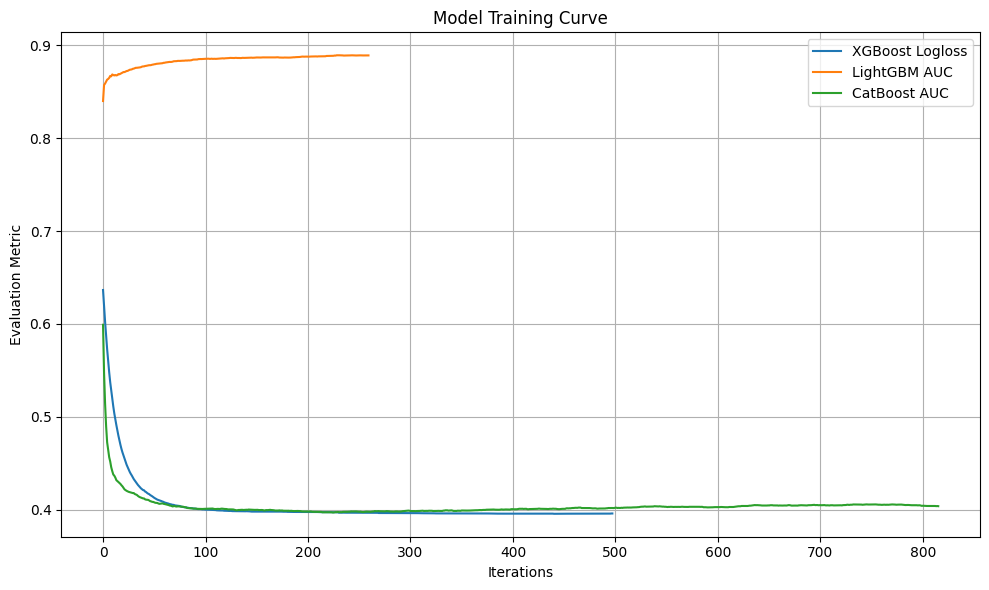

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(xgb_log['validation_0']['logloss'], label='XGBoost Logloss')
plt.plot(lgb_log['valid_0']['auc'], label='LightGBM AUC')
plt.plot(cat_log['validation']['Logloss'], label='CatBoost AUC')
plt.xlabel('Iterations')
plt.ylabel('Evaluation Metric')
plt.title('Model Training Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_curve.png')
plt.show()

### 7.3 特徵重要性分析

分析和比較不同模型的特徵重要性，找出對預測吸菸狀態最有影響力的特徵。

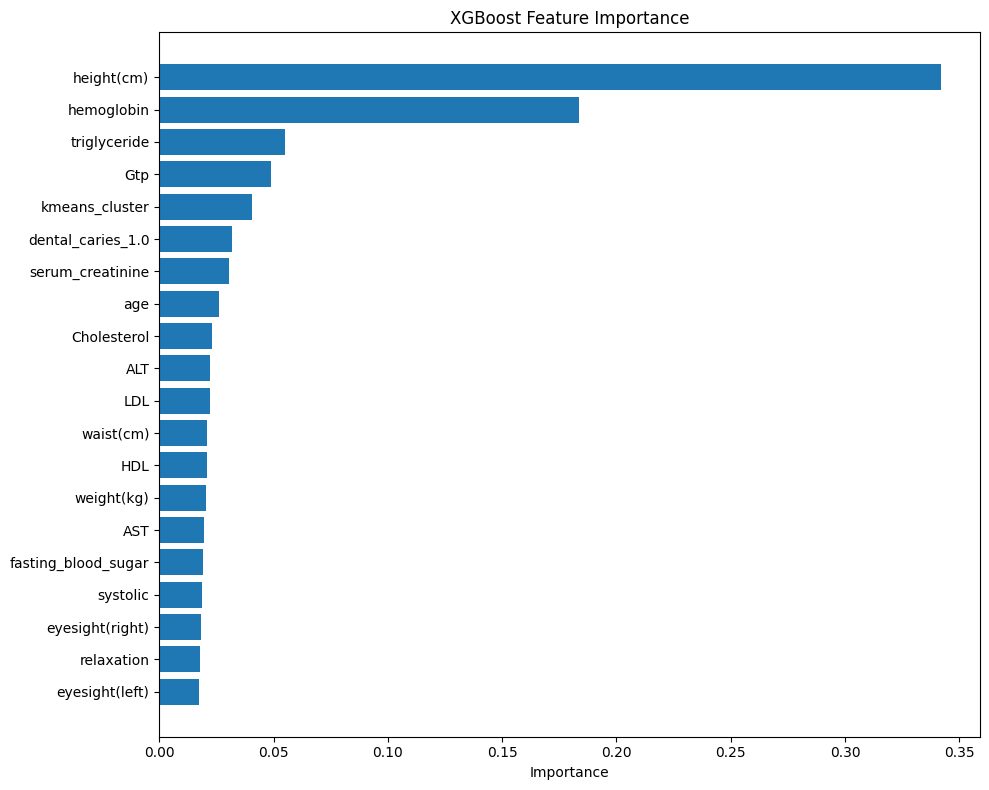

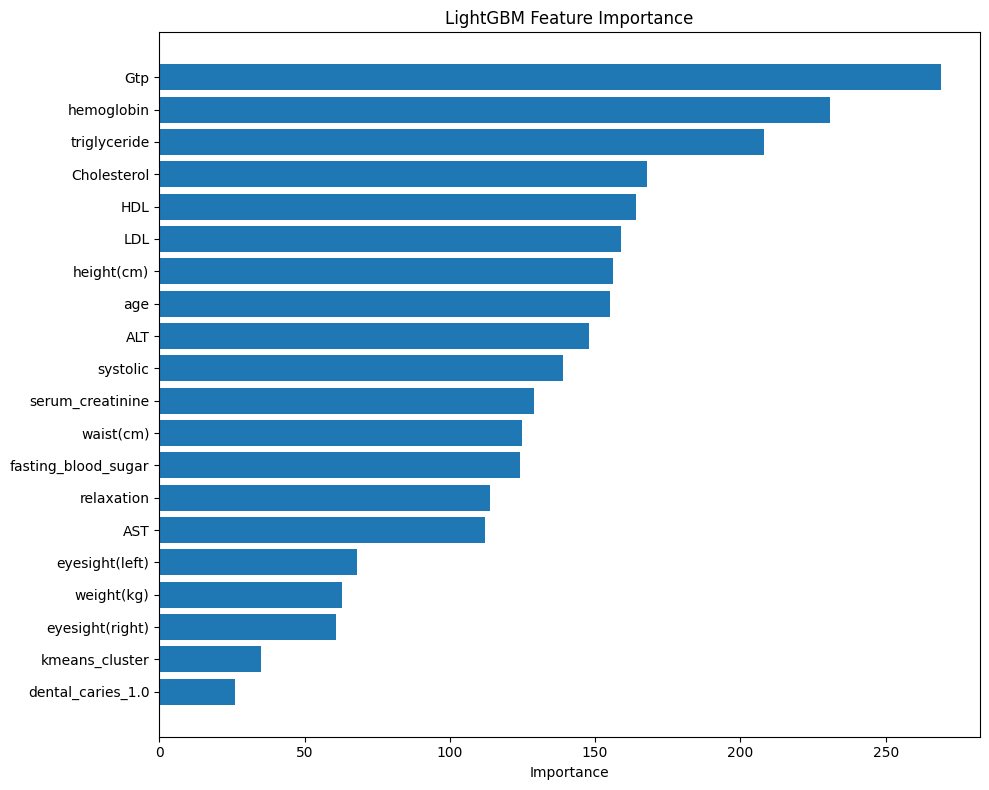

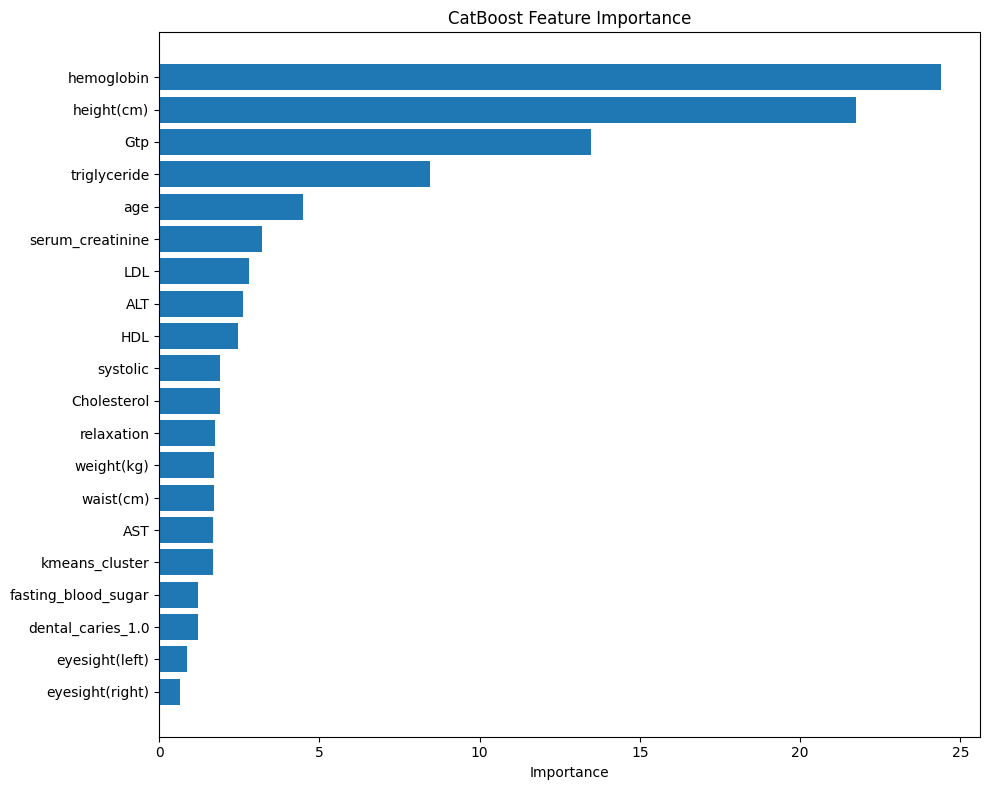

In [54]:
def plot_importance(importances, title, filename):
    df = pd.DataFrame({'Feature': features, 'Importance': importances})
    df = df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 8))
    plt.barh(df['Feature'][:20][::-1], df['Importance'][:20][::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Plot XGBoost feature importance
plot_importance(best_xgb.feature_importances_, "XGBoost Feature Importance", "feature_importance_xgb.png")

# Plot LightGBM feature importance
plot_importance(best_lgb.feature_importances_, "LightGBM Feature Importance", "feature_importance_lgb.png")

# Plot CatBoost feature importance
plot_importance(best_cat.get_feature_importance(), "CatBoost Feature Importance", "feature_importance_cat.png")

### 7.4 SHAP 值分析

使用 SHAP (SHapley Additive exPlanations) 來理解模型的決策過程和特徵對預測的影響。

 96%|=================== | 1440/1500 [00:22<00:00]       

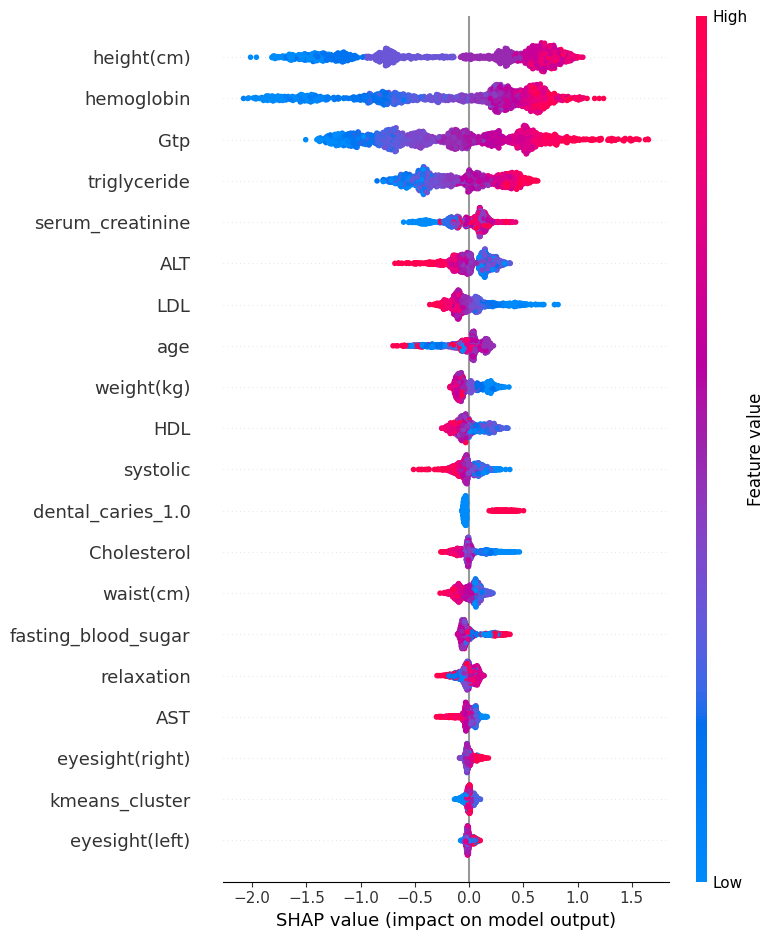

In [60]:
# 使用 XGBoost 模型進行 SHAP 值計算
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_val)

# 繪製 SHAP 摘要圖
shap.summary_plot(shap_values, X_val, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot.png")
plt.show()

100%|===================| 1496/1500 [00:14<00:00]        

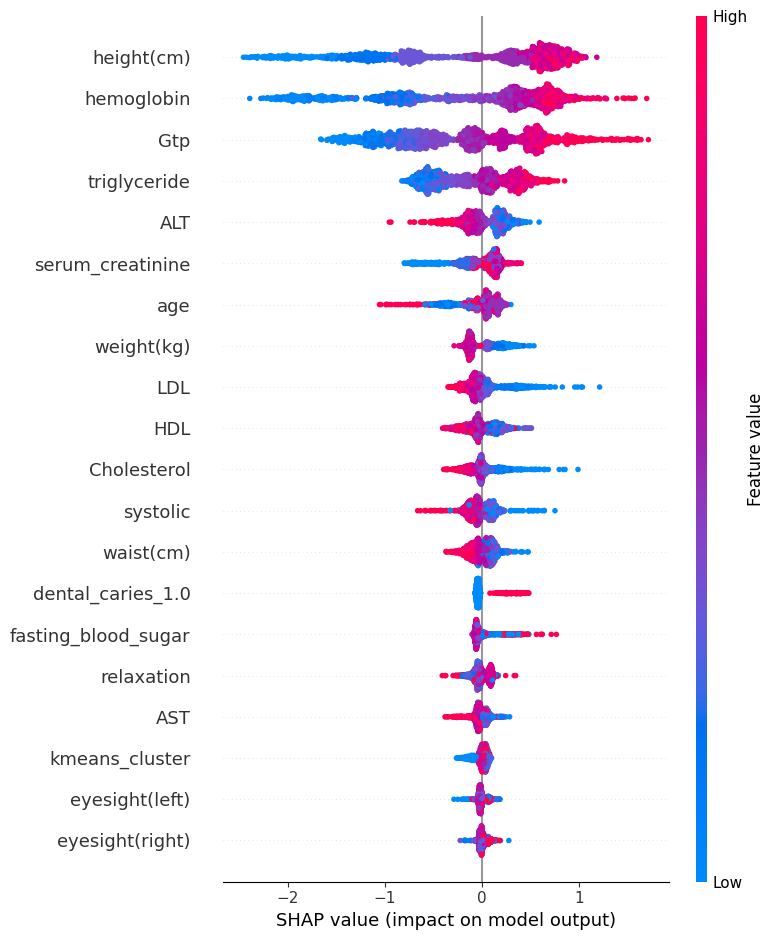

In [61]:
# 使用 LightGBM 模型進行 SHAP 值計算
explainer_lgb = shap.Explainer(best_lgb, X_train)
shap_values_lgb = explainer_lgb(X_val)

# 繪製 SHAP 摘要圖
shap.summary_plot(shap_values_lgb, X_val, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot_lgb.png")
plt.show()

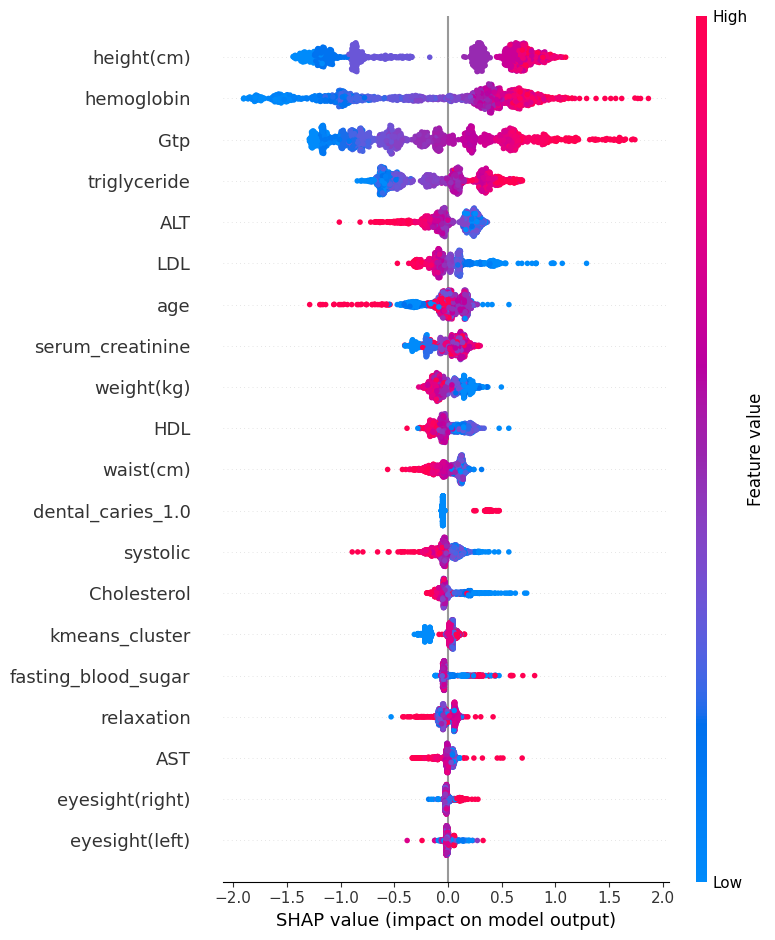

In [62]:
# 使用 CatBoost 模型進行 SHAP 值計算
explainer_cat = shap.Explainer(best_cat, X_train)
shap_values_cat = explainer_cat(X_val)

# 繪製 SHAP 摘要圖
shap.summary_plot(shap_values_cat, X_val, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot_cat.png")
plt.show()